## Load Data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [2]:
# Load cleanly
# data = pd.read_csv("stocks/AAPL.csv", index_col="Date", parse_dates=True)

# Test
data = pd.read_csv("test_stocks/AAPL.csv", index_col="Date", parse_dates=True)
data = data.loc["1983-01-01":"2025-05-02"]

# print(data.head())

# Compute log returns
data["LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))

# Add lagged log returns as features
for lag in range(1, 6):
    data[f"LogReturn_Lag{lag}"] = data["LogReturn"].shift(lag)

# Add percentage changes of other features
data["Open"] = data["Open"]
data["High"] = data["High"]
data["Low"] = data["Low"]
data["Close"] = data["Close"]
data["Volume"] = data["Volume"]

# Drop NaNs
data.dropna(inplace=True)

# Display prepared feature columns
print(data.head())

            Adj Close     Close      High       Low      Open     Volume  \
Date                                                                       
1983-01-11   0.100014  0.130022  0.131696  0.128348  0.128348    1388800   
1983-01-12   0.105594  0.137277  0.140625  0.131696  0.131696  176982400   
1983-01-13   0.105594  0.137277  0.138393  0.135045  0.137277   82275200   
1983-01-14   0.113320  0.147321  0.147321  0.137835  0.137835  184643200   
1983-01-17   0.117184  0.152344  0.154576  0.146205  0.147321  234864000   

            LogReturn  LogReturn_Lag1  LogReturn_Lag2  LogReturn_Lag3  \
Date                                                                    
1983-01-11   0.012958        0.044449       -0.057407       -0.037904   
1983-01-12   0.054297        0.012958        0.044449       -0.057407   
1983-01-13   0.000000        0.054297        0.012958        0.044449   
1983-01-14   0.070613        0.000000        0.054297        0.012958   
1983-01-17   0.033527        

In [3]:
# Save as CSV and then read it -- this is silly and I will remove this unnecessary
# step. But for now, let's keep it (I first started with CSV but then switched to
# yfinance)
# data.to_csv("data.csv")

# data = pd.read_csv("data.csv", index_col=0, parse_dates=True)
# data.head()

# Clean up metadata rows
data_clean = data.copy()
data_clean.index.name = "Date"

# Convert index to datetime if not already
data_clean.index = pd.to_datetime(data_clean.index)

# Convert columns to numeric
for col in data_clean.columns:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

# Drop rows with missing values
data_clean.dropna(inplace=True)

# Confirm cleanup
data_clean.head()

,Adj Close,Close,High,Low,Open,Volume,LogReturn,LogReturn_Lag1,LogReturn_Lag2,LogReturn_Lag3,LogReturn_Lag4,LogReturn_Lag5
Date,,,,,,,,,,,,
1983-01-11,0.100014,0.130022,0.131696,0.128348,0.128348,1388800,0.012958,0.044449,-0.057407,-0.037904,0.004141,0.055455
1983-01-12,0.105594,0.137277,0.140625,0.131696,0.131696,176982400,0.054297,0.012958,0.044449,-0.057407,-0.037904,0.004141
1983-01-13,0.105594,0.137277,0.138393,0.135045,0.137277,82275200,0.000000,0.054297,0.012958,0.044449,-0.057407,-0.037904
1983-01-14,0.113320,0.147321,0.147321,0.137835,0.137835,184643200,0.070613,0.000000,0.054297,0.012958,0.044449,-0.057407
1983-01-17,0.117184,0.152344,0.154576,0.146205,0.147321,234864000,0.033527,0.070613,0.000000,0.054297,0.012958,0.044449


## Train test split

Here I have a note: should we split the data in time span or number of datas. like 70% of time frame or 70% of the data as training data

In [4]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    "Open", "High", "Low", "Close", "Volume",
    "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
]
target = "LogReturn"

X = data_clean[features]
y = data_clean[target]

dates = data_clean.index.unique()
n = len(dates)

train_end = dates[int(n * 0.7)]
val_end = dates[int(n * 0.85)]

# Split data by date ranges
X_train = X.loc[:train_end]
y_train = y.loc[:train_end]

X_val = X.loc[train_end + pd.Timedelta(days=1) : val_end]
y_val = y.loc[train_end + pd.Timedelta(days=1) : val_end]

X_test = X.loc[val_end + pd.Timedelta(days=1):]
y_test = y.loc[val_end + pd.Timedelta(days=1):]

# Display summary
{
    "Train shape": X_train.shape,
    "Validation shape": X_val.shape,
    "Test shape": X_test.shape,
    "Features": X.columns.tolist()
}

{'Train shape': (7465, 10),
 'Validation shape': (1599, 10),
 'Test shape': (1599, 10),
 'Features': ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'LogReturn_Lag1',
  'LogReturn_Lag2',
  'LogReturn_Lag3',
  'LogReturn_Lag4',
  'LogReturn_Lag5']}

## Make model and train it

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train SVR with RBF kernel
svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)
svr.fit(X_train_scaled, y_train)

# Predict on validation and test
y_val_pred = svr.predict(X_val_scaled)
y_test_pred = svr.predict(X_test_scaled)

# Display basic stats of predictions
{
    "Val Pred Mean": y_val_pred.mean(),
    "Val Pred Std": y_val_pred.std(),
    "Test Pred Mean": y_test_pred.mean(),
    "Test Pred Std": y_test_pred.std()
}

{'Val Pred Mean': np.float64(0.0006360469512173856),
 'Val Pred Std': np.float64(0.012534404809252121),
 'Test Pred Mean': np.float64(-0.01170027552584272),
 'Test Pred Std': np.float64(6.361854408916626e-05)}

## Backtest this model

In [6]:
y_test_pred[-50:]

array([-0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513,
       -0.01170513, -0.01170513, -0.01170513, -0.01170513, -0.01170513])

In [7]:
import numpy as np

# Generate positions
threshold = 0.001
val_positions = np.where(y_val_pred > threshold, 1, np.where(y_val_pred < -threshold, -1, 0))
test_positions = np.where(y_test_pred > threshold, 1, np.where(y_test_pred < -threshold, -1, 0))

# Compute strategy returns
val_strategy_returns = val_positions * y_val.values
test_strategy_returns = test_positions * y_test.values

# Dollar returns with $1M starting capital
initial_capital = 1000000
val_dollar_returns = initial_capital * (np.exp(np.cumsum(val_strategy_returns)) - 1)
test_dollar_returns = initial_capital * (np.exp(np.cumsum(test_strategy_returns)) - 1)

# Cumulative return
val_cum_return = np.exp(np.cumsum(val_strategy_returns)) - 1
test_cum_return = np.exp(np.cumsum(test_strategy_returns)) - 1

# Sharpe ratio (annualized, assuming 252 trading days)
val_sharpe = np.mean(val_strategy_returns) / np.std(val_strategy_returns) * np.sqrt(252)
test_sharpe = np.mean(test_strategy_returns) / np.std(test_strategy_returns) * np.sqrt(252)

# Final return and sharpe
returns = {
    "Validation Cumulative Return": val_cum_return[-1],
    "Validation Sharpe Ratio": val_sharpe,
    "Test Cumulative Return": test_cum_return[-1],
    "Test Sharpe Ratio": test_sharpe
}

# Output final capital and profits for original model
capital = {
    "Final Val Capital": val_dollar_returns[-1] + initial_capital,
    "Final Test Capital": test_dollar_returns[-1] + initial_capital,
    "Total Val Profit": val_dollar_returns[-1],
    "Total Test Profit": test_dollar_returns[-1]
}

def print_formatted_metrics(returns, capital):
    """
    Print returns and capital metrics in a nicely formatted way.

    Parameters:
    - returns: Dictionary containing return and Sharpe ratio metrics
    - capital: Dictionary containing capital and profit metrics
    """
    print("----- PERFORMANCE METRICS -----\n")

    print("RETURNS")
    print(f"Validation Cumulative Return: {returns['Validation Cumulative Return']:.2%}")
    print(f"Validation Sharpe Ratio:      {returns['Validation Sharpe Ratio']:.4f}")
    print(f"Test Cumulative Return:       {returns['Test Cumulative Return']:.2%}")
    print(f"Test Sharpe Ratio:            {returns['Test Sharpe Ratio']:.4f}")

    print("\nCAPITAL")
    print(f"Final Val Capital:  ${capital['Final Val Capital']:,.2f}")
    print(f"Final Test Capital: ${capital['Final Test Capital']:,.2f}")
    print(f"Total Val Profit:   ${capital['Total Val Profit']:,.2f}")
    print(f"Total Test Profit:  ${capital['Total Test Profit']:,.2f}")

print_formatted_metrics(returns, capital)

----- PERFORMANCE METRICS -----

RETURNS
Validation Cumulative Return: 12596.62%
Validation Sharpe Ratio:      3.1348
Test Cumulative Return:       -80.91%
Test Sharpe Ratio:            -0.8176

CAPITAL
Final Val Capital:  $126,966,183.13
Final Test Capital: $190,930.12
Total Val Profit:   $125,966,183.13
Total Test Profit:  $-809,069.88


In [8]:
test_pnl = initial_capital * (np.exp(test_positions * y_test.values) - 1)
average_pnl = np.mean(test_pnl)
print(f"Average PnL (with trade size $1MM):  ${average_pnl:,.2f}")
print("Average PnL percentage:"  f"  {average_pnl / initial_capital * 100:.2f}%")

Average PnL (with trade size $1MM):  $-832.93
Average PnL percentage:  -0.08%


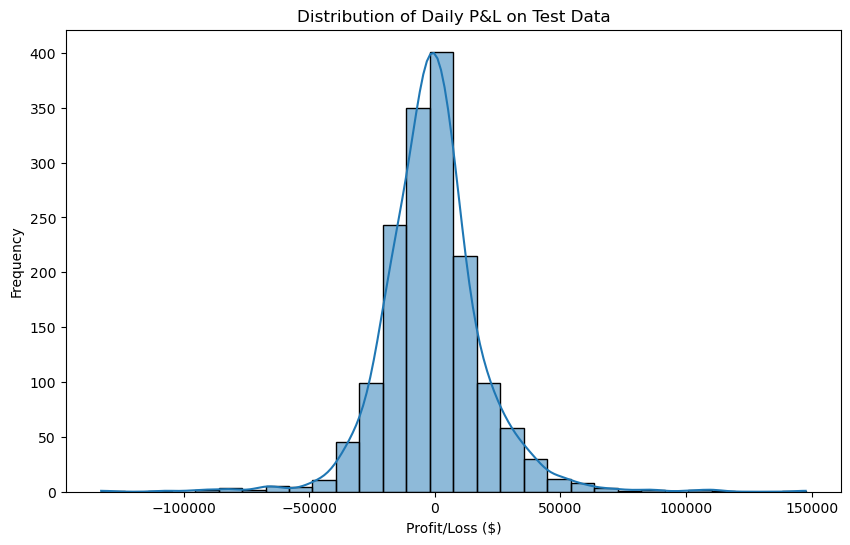

In [9]:
# prompt: plot test_pnl in an easy to comprehend way. i want to see the distribution of profits vs loss

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'test_pnl' is defined as in the provided code

plt.figure(figsize=(10, 6))
sns.histplot(test_pnl, kde=True, bins=30)
plt.title('Distribution of Daily P&L on Test Data')
plt.xlabel('Profit/Loss ($)')
plt.ylabel('Frequency')
plt.show()


In [10]:
type(X_test.Close)

pandas.core.series.Series

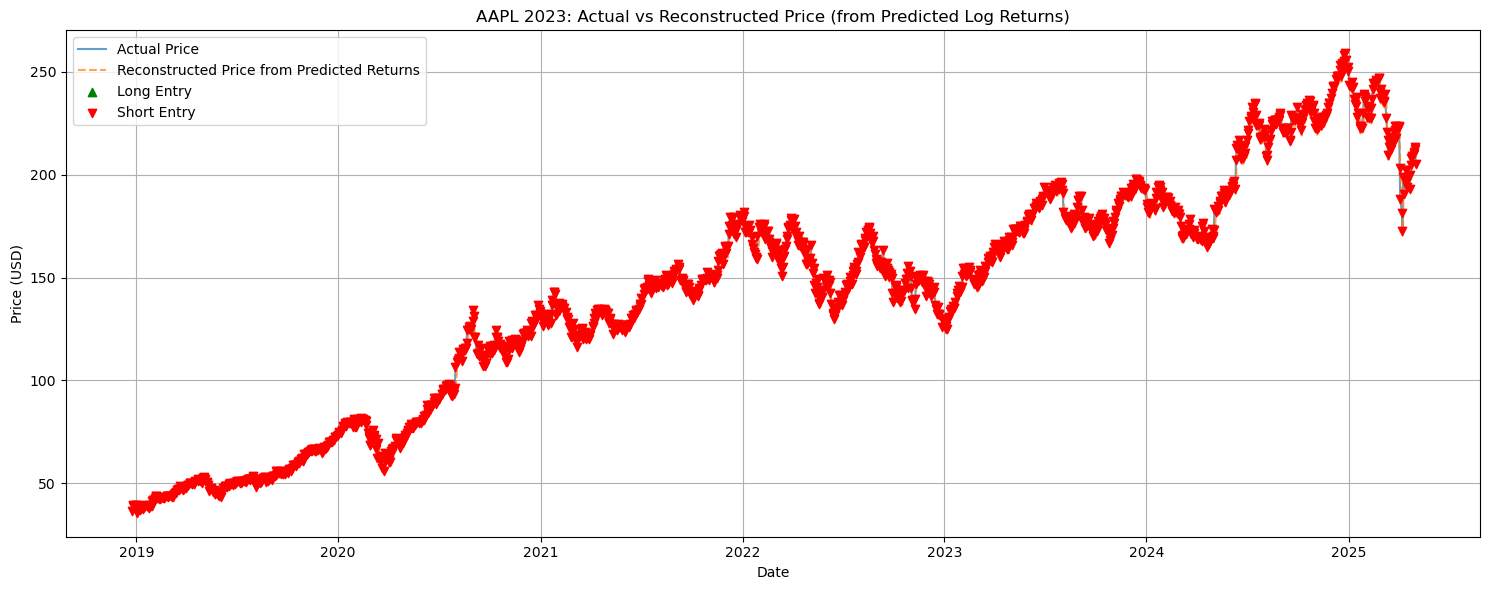

In [11]:
# Long/Short markers
long_signals = (test_positions == 1)
short_signals = (test_positions == -1)

# Get dates
test_dates = y_test.index
plot_dates = test_dates[1:] 

# Assume: prices is the actual price series for test window (2023)
P_t = X_test.Close[:-1]              # P_t for days 0 to N-2
r_hat_t_plus_1 = y_test_pred[1:]      # predicted log return for days 1 to N-1
P_hat_t_plus_1 = P_t * np.exp(r_hat_t_plus_1)  # predicted P_{t+1}


# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_dates, X_test.Close, label="Actual Price", alpha=0.7)
plt.plot(plot_dates, P_hat_t_plus_1, label="Reconstructed Price from Predicted Returns", linestyle="--", alpha=0.7)

plt.scatter(plot_dates[long_signals[1:]], X_test.Close.values[1:][long_signals[1:]], marker='^', color='green', label='Long Entry', zorder=5)
plt.scatter(plot_dates[short_signals[1:]], X_test.Close.values[1:][short_signals[1:]], marker='v', color='red', label='Short Entry', zorder=5)

plt.title("AAPL 2023: Actual vs Reconstructed Price (from Predicted Log Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
sum(test_positions)

np.int64(-1599)